# Map Projections and Coordinate Systems
Course at Ghent University, Department of Geography  
Professor Frank Canters

## Session 4: Cylindrical Projections and Projection Optimisation
Performed in Python using Jupyter Notebook.

Written by Manuel Claeys Bouuaert, <manuel.claeysbouuaert@ugent.be>, 2015

Choosing a good projection for a specific area means choosing:

- projection type
- projection parameters (standard parallel, Miller coefficients, ...)
- coordinates of pseudopole  

In this session, we will work with small scale projections (world maps) and only change projection parameters.

A good choice of the projection parameters is one which minimises the average distortion over the concerned area:  

$$ E = \frac{1}{S} \int_S e \,\mathrm{d}S $$

- $E$ is the average distortion
- $S$ is the concerned area on the sphere or ellipsoide
- $e$ is the local distortion
- $\mathrm{d}S$ is the area of a local infinitessimal surface element

In practice, this integral is approximated by a discrete sum, by dividing the sphere into small cells:

$$ E = \frac{1}{S} \sum_{i} e_i \, S_i $$

$$ S = \sum_{i} S_i $$

- $E$ is the average distortion
- $S$ is the concerned area on the sphere or ellipsoide
- $e_i$ is the local distortion at the center of a cell
- $S_i$ is the area of a local cell

Most (non-poly/pseudo) cylindrical projections are invariant under mirroring of $\phi$ or translation in $\lambda$, and hence their distortions are too. In those cases, this symmetry means we must only perform a summation over one half meridian: $\phi = 0 \rightarrow \frac{\pi}{2}$. 

When deviding the globe ($\phi = -\frac{\pi}{2} \rightarrow \frac{\pi}{2}$ and $\lambda = -\pi \rightarrow \pi$) into cells of $\Delta\lambda$ and $\Delta\phi$, the area of a cell scales with $\cos\phi$.  
The area of the cell at $(\phi_i,\lambda_i)$ is $S_i = P_i \cos{\phi_i} \, \Delta\phi \, \Delta\lambda$  
Since $\Delta\phi$ and $\Delta\lambda$ are independent of $i$ and also appear in $S$, they cancel out, leading to $S_i = P_i \cos{\phi_i}$.

The weight factor $P_i$ can be used to select a specific area, by putting $P_i = 1$ there and $P_i = 0$ elsewhere.

Which local distortions are used?  

- Local angular distortion: $e_{an,i} = 2\Omega_i = 2\arcsin(\frac{a_i-b_i}{a_i+b_i})$
- Local area distortion: $e_{ar,i} = \sigma_i^p-1 = (a_ib_i)^p-1$
- Local mean linear scale distortion: $e_{ab,i} = \frac{a_i^q+b_i^r}{2}-1$

To ensure that enlarging and shrinking with the same factor has the same weight, we use

- $p$ = 1 if $\sigma_i$ ≥ 1 and $p$ = -1 if $\sigma_i$ < 1
- $q$ = 1 if $a_i$ ≥ 1 and $q$ = -1 if $a_i$ < 1
- $r$ = 1 if $b_i$ ≥ 1 and $r$ = -1 if $b_i$ < 1.

These are all 'linear distortions' and are used in (1). Other authors have used similar measures, but square the distortions in order to obtain positive values ($e_{an,i}=(\sigma-1)^2$, $e_{ab,i}=\frac{1}{2}((a-1)^2+(b-1)^2$). This gives more weight to large distortions, which is yields unfavorable results for small scale projections. Some authors have proposed to use the logarithmic function in distortions. This also allows to attribute enlarging and shrinking with the same factor the same weight, and additionally weights extreme distortions relatively less.  
(1) *Canters, F., 2002. Small-scale Map Projection Design. CRC Press.*

- Equivalent projections ($e_{ar,i} = 0$) $\rightarrow$ minimise $e_{an,i}$
- Conformal projections ($e_{an,i} = 0$) $\rightarrow$ minimise $e_{ar,i}$
- other projections $\rightarrow$ minimise $e_{ar,i}$, $e_{an,i}$ and/or $e_{ab,i}$

### Exercises in Python

Load modules

In [1]:
%matplotlib inline 
# show plots inline
import os # to access UNIX commandline
import urllib.request # to download files
import zipfile # to unzip files
import numpy as np # to use arrays etc
from scipy import misc # to read images etc
import matplotlib.pyplot as plt # to plot
import matplotlib.cm as cm # to have colormaps
from ipywidgets import * # to have interactive widgets
from IPython.display import display, HTML # to have interactive widgets

Define latitudes $\phi$ of cells. (From here on, we drop the index $i$)  
We are asked to use cells with an interval of 1° (in stead of 2.5°).

In [2]:
lat_deg = np.arange(0,90,1)+1/2
lat=lat_deg/180*np.pi # use radians by default
print(lat_deg) # only use degrees when printing or plotting

[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5  70.5  71.5
  72.5  73.5  74.5  75.5  76.5  77.5  78.5  79.5  80.5  81.5  82.5  83.5
  84.5  85.5  86.5  87.5  88.5  89.5]


Define weight factor $P$.  
We will consider the entire sphere by default.

In [3]:
P_ones = np.ones(len(lat))
P = P_ones

The values `lat` and `P` will be used as global parameters

Define functions for different local distortions $e_{..}$ times the local surface area $S$.  
They take the local values of $h$ and $k$ as input: the scale factor along the meridians and parallels.  

In [4]:
def eanS(h,k):
    global lat, P
    a = np.amax(np.vstack((h,k)),axis=0)
    b = np.amin(np.vstack((h,k)),axis=0)
    twoOmega = 2*np.arcsin((a-b)/(a+b))
    eanS = twoOmega*P*np.cos(lat)
    return eanS
def earS(h,k):
    global lat, P
    a = np.amax(np.vstack((h,k)),axis=0)
    b = np.amin(np.vstack((h,k)),axis=0)
    sigma = a*b
    p = np.sign(sigma-1)
    earS = (np.power(sigma,p)-1)*P*np.cos(lat)
    return earS
def eabS(h,k):
    global lat, P
    a = np.amax(np.vstack((h,k)),axis=0)
    b = np.amin(np.vstack((h,k)),axis=0)
    q = np.sign(a-1)
    r = np.sign(b-1)
    eabS = ((np.power(a,q)+np.power(b,r))/2-1)*P*np.cos(lat)
    return eabS

The average distortion $E$ is the average of the local distortion $e$

In [5]:
def E(eS):
    global lat, P
    S = np.sum(P*np.cos(lat))
    E = np.sum(eS)/S
    return E

### Ex. 1: Equivalent Cylindrical Projection with varying standard parallel  
Given the secant Equivalent Cylindrical Projection, which value for standard parallel yields the lowest angular distortion over the entire sphere?

The Equivalent Cylindrical Projection:

$ x = R \lambda \cos \phi_0 $  
$ y = \frac{R}{\cos \phi_0} \sin \phi $  

With (see course notes slide 4.23)

$ h = \frac{\cos \phi}{\cos \phi_0} $  
$ k = \frac{\cos \phi_0}{\cos \phi} $

Define $h$ and $k$ for this projection, for varying $\phi_0$

In [6]:
def h_ecp_lat0(lat0):
    global lat
    h = np.cos(lat)/np.cos(lat0)
    return h
def k_ecp_lat0(lat0):
    global lat
    k = np.cos(lat0)/np.cos(lat)
    return k

Plot the local angular distortion $\times$ surface: $e_{an} \, S$.

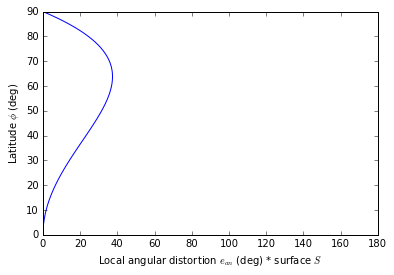

In [7]:
def plt_eanS_ecp_lat0(lat0):
    global lat, P
    h = h_ecp_lat0(lat0)
    k = k_ecp_lat0(lat0)
    f, ax = plt.subplots(1) # make figure and axis
    ax.plot(eanS(h,k)*180/np.pi,lat*180/np.pi)
    ax.set_xlabel('Local angular distortion $e_{an}$ (deg) * surface $S$')
    ax.set_ylabel('Latitude $\phi$ (deg)')
    ax.set_xlim(xmin=0,xmax=180)
    plt.show()
    
v = interactive(plt_eanS_ecp_lat0, lat0 = (0,90/180*np.pi,5/180*np.pi));
display(v)

Notice:

- Zero local angular distortion at $\phi = \frac{\pi}{2}$ because $\cos(\phi) = 0$  
- Zero local angular distortion at $\phi = \phi_0$ because no distortion at standard parallel

For which $\phi_0$ is the surface between the curve and the $y$-axis minimal?

Compute and plot average angular distortion $E_{an}$ for $\phi_0$ = 0°, 5°, 10°, ... 60°.

In [8]:
lat0_range = np.arange(0,95,5)/180*np.pi

In [9]:
Ean_ecp_lat0 = np.zeros(0) # create empty array

for lat0 in lat0_range:
    h = h_ecp_lat0(lat0)
    k = k_ecp_lat0(lat0)
    Ean_ecp_lat0 = np.append(Ean_ecp_lat0,E(eanS(h,k)))

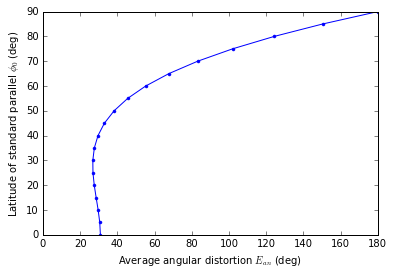

In [11]:
f, ax = plt.subplots(1) # make figure and axis
ax.plot(Ean_ecp_lat0*180/np.pi,lat0_range*180/np.pi,'b.-')
ax.set_xlabel('Average angular distortion $E_{an}$ (deg)')
ax.set_ylabel('Latitude of standard parallel $\phi_0$ (deg)')
ax.set_xlim(xmin=0)
plt.show()

The average angular distortion is the smalles for $\phi_0$ = 30°.

Compare this to the various known secant Equivalent Cylindrical Projections:

- Lambert $\phi_0$ = 0°
- Behrmann $\phi_0$ = 30°
- Gall-Peeters $\phi_0$ = 45°

Behrmann correctly computed position for the standard parallels in 1910, by minimising the angular distortion!

The Behrmann Projection  
![Behrmann Projection](https://upload.wikimedia.org/wikipedia/commons/f/f5/Behrmann_projection_SW.jpg)

### Ex. 1-bis: Equivalent Cylindrical Projection with varying Standard Parallel, weighted with landmass
Redo these calculations while ony averaging over land areas.

Download land polygons Shapefile from Natural Earth database

In [10]:
if not os.path.exists('downloads'):
    os.makedirs('downloads')
if not os.path.isfile('downloads/ne_110m_land.shp'): # Do this only if it doesn't already exist
    urllib.request.urlretrieve('http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/physical/ne_110m_land.zip','downloads/ne_110m_land.zip')
    zf = zipfile.ZipFile('downloads/ne_110m_land.zip')
    zf.extractall('downloads')

Convert Shapefile to raster image.

In [11]:
os.system('gdal_rasterize -a scalerank -ot Byte -te -180 -90 180 90 -tr 1.0 1.0 -l ne_110m_land downloads/ne_110m_land.shp land.tif')

0

This calls the `gdal_rasterize` function through a terminal command (UNIX). It reads the `ne_110m_land.shp` file and creates a rasterized version: the `land.tif` file. The following options are specified:  
* `-a scalerank` : the name of the attribute used in the input file
* `-ot Byte` : the output is binairy (avoid using the default Float64)  
* `-te -180 -90 180 90` : the input is considerd in the range x=-180...180 and y=-90...90 (default projection EPSG::4326)  
* `-tr 1.0 1.0` : the target resolution is one pixel per 1.0-by-1.0 input block.  
* `-l ne_110m_land` : the name of the layer to be considered

Alternatively, one could use the osgeo.gdal package:  
`from osgeo import gdal`  
`raster = gdal.RasterizeLayer(...)`

Load the image into a variable. It is stored as a `numpy.ndarray`.

numpy.ndarray

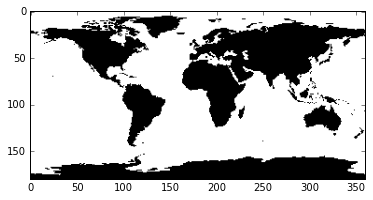

In [12]:
land_longlat = misc.imread('land.tif')
plt.imshow(land_longlat,cmap=cm.Greys)
type(land_longlat)

Count number of longitudes covered with land, by lattitude.

In [14]:
land_lat=land_longlat.sum(axis=1) # Sum over second dimension = longitudes

Plot the result

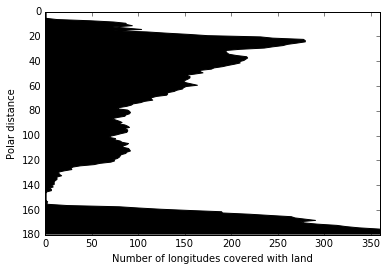

In [15]:
f, ax = plt.subplots(1) # make figure and axis
# ax.plot(land_lat,np.arange(0,180),'k')
ax.fill_betweenx(np.arange(0,180), np.zeros(len(land_lat)), land_lat, color = 'k')
ax.set_xlabel('Number of longitudes covered with land')
ax.set_ylabel('Polar distance')
ax.set_xlim(xmax=360)
plt.gca().invert_yaxis()
plt.show()

Convert this into values for $P$: a ratio of land, for latitudes from 0 to 90  
Plot $P$

In [16]:
P_land = (land_lat[-91:-181:-1] + land_lat[90:180:1])/(2*360)

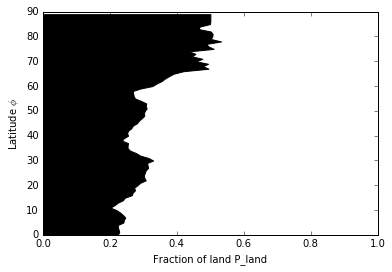

In [17]:
f, ax = plt.subplots(1) # make figure and axis
# ax.plot(P_land,np.arange(0,90)+0.5,'k')
ax.fill_betweenx(np.arange(0,90), np.zeros(len(P_land)), P_land, color = 'k')
ax.set_xlabel('Fraction of land P_land')
ax.set_ylabel('Latitude $\phi$')
ax.set_xlim(xmin=0,xmax=1)
plt.show()

We use this $P$, and redo the calculations of the average angular distortion $E_{an}$

In [18]:
P = P_land

In [19]:
Ean_ecp_lat0_land = np.zeros(0)

for lat0 in lat0_range:
    h = h_ecp_lat0(lat0)
    k = k_ecp_lat0(lat0)
    Ean_ecp_lat0_land = np.append(Ean_ecp_lat0_land,E(eanS(h,k)))

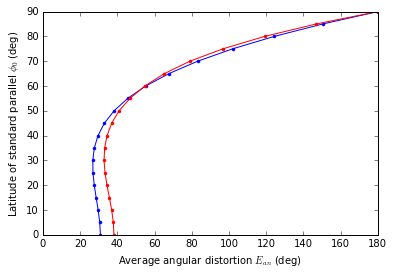

In [20]:
f, ax = plt.subplots(1) # make figure and axis
ax.plot(Ean_ecp_lat0*180/np.pi,lat0_range*180/np.pi,'b.-')
ax.plot(Ean_ecp_lat0_land*180/np.pi,lat0_range*180/np.pi,'r.-')
ax.set_xlabel('Average angular distortion $E_{an}$ (deg)')
ax.set_ylabel('Latitude of standard parallel $\phi_0$ (deg)')
ax.set_xlim(xmin=0)
plt.show()

The optimal value for $\phi_0$ is still around 30°.  

There is quite some landmass is at high latitudes. For normal, low values of $\phi_0$, the angular distortion is large at high latitudes. Therefore, the average angular distortion $E_{an}$ is higher for these $\phi_0$ then when landmass is ignored, and the optimal value for $\phi_0$ shifts (slightly) towards higher latitudes (but stays near 30°).

We reset $P$ to ones, and ignore landmass in the following exercises

In [21]:
P = P_ones

We have chosen $\phi_0$ to minimise the average angular distortion $E_{an}$ in the Equivalent Cylindrical Projection ($E_{ar}=0$).  

Could we choose $\phi_0$ to minimise the average area distortion $E_{an}$ in the Conformal Cylindrical Projection (Mercator) ($E_{an}=0$)? Would this be a usefull way to obtain a good worldmap?

The problem with Mercator is the ever increasing distance between the parallels. 

- This makes it a bad projection for a worldmap in any circumstance.
- The local area distortion $e_{ar}$ is so large at the poles, that this will dominate the average area distoriton $E_{ar}$ and lead to a bad choice for $\phi_0$.

Possible solutions?

- Stop integration at a $\phi_{max}$, example $\phi_{max}=80°$
- Only integrate over landmass (excluding Antactrica)
- Use logarithmic distortion measures (will make extreme distortions count less, but still a lot)
- Modify projection to bring poles at finite distance (see Ex. 2)

### Ex. 2: Conformal Cylindrical Projection with varying Miller Coefficients - Miller Projection
Given the (non-secant) Conformal Cylindrical Projection (Mercator Projection), addapted with Miller coefficient $C$, which value for this coefficient yields the lowest angular and areal distortion over the entire sphere?

The American cartographer O.M. Miller added a parameter $C$ to the equations of the Mercator Projection:

$ x = R \lambda $  
$ y = C R \ln \tan ( \frac{\pi}{4} + \frac{\phi}{2C} )$  

$C$ allow to reduce the wide spacing of the parallels towards the poles, and brings the poles to finite distance.

With $C = 1$ for normal Mercator. For high $C$ the projection starts to behave like the Equidistant Cylindrical Projection.

Because of the added $C$, we must first again derive $h$ and $k$ analyticaly.

Determine

$h = \frac{\mathrm{d}y}{R\mathrm{d}\phi}$  
$k = \frac{\mathrm{d}x}{R\cos\phi\mathrm{d}\lambda}$

Solution

$h = \frac{1}{\cos\frac{\phi}{C}}$  
$k = \frac{1}{\cos\phi}$

Define $h$ and $k$ for this projection, for varying $C$

In [22]:
def h_ccp_C(C):
    global lat
    h = 1/np.cos(lat/C)
    return h
def k_ccp_C(C):
    global lat
    k = 1/np.cos(lat)
    return k

Plot the local angular and area distortion $\times$ surface: $e_{an} \, S$ and $e_{ar} \, S$

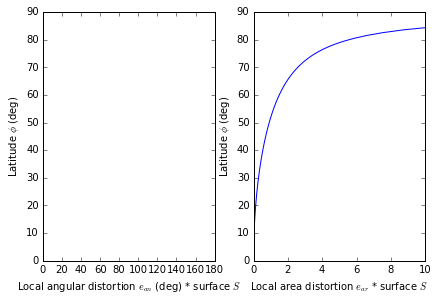

In [23]:
def plt_eanS_earS_ccp_C(C):
    global lat, P
    h = h_ccp_C(C)
    k = k_ccp_C(C)
    f, (ax1, ax2) = plt.subplots(1, 2) # make figure and axis
    f.tight_layout()
    ax1.plot(eanS(h,k)*180/np.pi,lat*180/np.pi)
    ax1.set_xlabel('Local angular distortion $e_{an}$ (deg) * surface $S$')
    ax1.set_ylabel('Latitude $\phi$ (deg)')
    ax1.set_xlim(xmin=0,xmax=180)
    ax2.plot(earS(h,k),lat*180/np.pi)
    ax2.set_xlabel('Local area distortion $e_{ar}$ * surface $S$')
    ax2.set_ylabel('Latitude $\phi$ (deg)')
    ax2.set_xlim(xmax=10)
    plt.show()
    
v = interactive(plt_eanS_earS_ccp_C, C = (1,1.8,0.1));
display(v)

Notice how the local angular distortion $e_{an}$ grows and local area distortion $e_{ar}$ shrinks as $C$ grows.

Also (see earlier remarks on Mercator Projection):  
For $C=1$, at $\phi = \frac{\pi}{2}$, $S = P \cos \phi = 0$, but this is not able to bring the local area distortion $e_{ar}$ to finite values!

Compute and plot the average angular distortion $E_{an}$ and average area distortion $E_{ar}$ for $C$ = 1, 1.1, ..., 1.7.

In [24]:
C_range = np.arange(1,1.8,0.1)

In [25]:
Ean_ccp_C = np.zeros(0)

for C in C_range:
    h = h_ccp_C(C)
    k = k_ccp_C(C)
    Ean_ccp_C = np.append(Ean_ccp_C,E(eanS(h,k)))
    
Ear_ccp_C = np.zeros(0)

for C in C_range:
    h = h_ccp_C(C)
    k = k_ccp_C(C)
    Ear_ccp_C = np.append(Ear_ccp_C,E(earS(h,k)))

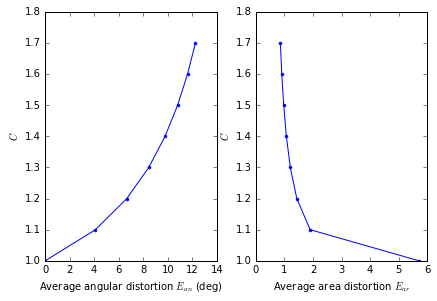

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2) # make figure and axis
f.tight_layout()
ax1.plot(Ean_ccp_C*180/np.pi,C_range,'b.-')
ax1.set_xlabel('Average angular distortion $E_{an}$ (deg)')
ax1.set_ylabel('$C$')
ax1.set_xlim(xmin=0)
ax2.plot(Ear_ccp_C,C_range,'b.-')
ax2.set_xlabel('Average area distortion $E_{ar}$')
ax2.set_ylabel('$C$')
ax.set_xlim(xmin=0)
plt.show()

The same trend is observed: the average angular distortion $E_{an}$ grows and the avergae area distortion $E_{ar}$ shrinks as $C$ grows. The projection is conformal for $C=1$, and loses its conformaty for $C>1$ in return for lower area distortion.

Notice how $C=1.1$ leads to a dramatic reduction of $E_{ar}$ and only a relatively small increase in $E_{an}$.

It is difficult to find an optimal value for $C$ by comparing both measures, since they have different units (degrees/radians vs. dimensionless). This can, for example, be done using a uniform measure like the average mean linear scale factor (Ex.4.).

Miller proposed two values for $C$ (1942): 

- $C = 1.25$, known as 'the' Miller Cylindrical Projection (EPSG:54003)
- $C = 1.5$

The Miller Projection  
![Miller Projection](https://upload.wikimedia.org/wikipedia/commons/5/5f/Miller_projection_SW.jpg)

### Ex. 3: Equivalent Cylindrical Projection with varying Miller Coefficients
Given the (non-secant) Equivalent Cylindrical Projection, addapted with Miller coefficient $C$, which value for this coefficient yields the lowest angular and areal distortion over the entire sphere?

We add a coefficient $C$ to the Equivalent Cylindrical Projection, in the same fashion as with Miller:

$ x = R \lambda $  
$ y = C R \sin \frac{\phi}{C}$  

This time, $C$ allow to enlarge the narrow spacing of the parallels towards the poles.

With $C = 1$ for normal equivalent. For high $C$ the projection also starts to behave like the Equidistant Cylindrical Projection.

Because of the added $C$, we must first again derive $h$ and $k$ analyticaly.

Determine

$h = \frac{\mathrm{d}y}{R\mathrm{d}\phi}$  
$k = \frac{\mathrm{d}x}{R\cos\phi\mathrm{d}\lambda}$

Solution

$h = \cos\frac{\phi}{C}$  
$k = \frac{1}{\cos\phi}$

Define $h$ and $k$ for this projection, for varying $C$

In [27]:
def h_ecp_C(C):
    global lat
    h = np.cos(lat/C)
    return h
def k_ecp_C(C):
    global lat
    k = 1/np.cos(lat)
    return k

Plot the local angular and area distortion $\times$ surface: $e_{an} \, S$ and $e_{ar} \, S$

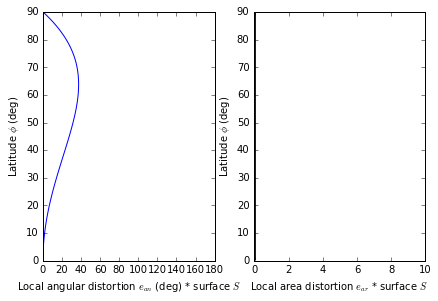

In [28]:
def plt_eanS_earS_ecp_C(C):
    global lat, P
    h = h_ecp_C(C)
    k = k_ecp_C(C)
    f, (ax1, ax2) = plt.subplots(1, 2) # make figure and axis
    f.tight_layout()
    ax1.plot(eanS(h,k)*180/np.pi,lat*180/np.pi)
    ax1.set_xlabel('Local angular distortion $e_{an}$ (deg) * surface $S$')
    ax1.set_ylabel('Latitude $\phi$ (deg)')
    ax1.set_xlim(xmin=0,xmax=180)
    ax2.plot(earS(h,k),lat*180/np.pi)
    ax2.set_xlabel('Local area distortion $e_{ar}$ * surface $S$')
    ax2.set_ylabel('Latitude $\phi$ (deg)')
    ax2.set_xlim(xmax=10)
    plt.show()

v = interactive(plt_eanS_earS_ecp_C, C = (1,1.8,0.1));
display(v)

Notice how the local angular distortion $e_{an}$ shrinks and local area distortion $e_{ar}$ grows as $C$ grows.

Compute and plot the average angular distortion $E_{an}$ and average area distortion $E_{ar}$ for $C$ = 1, 1.1, ..., 1.7.

In [29]:
C_range = np.arange(1,1.8,0.1)

Ean_ecp_C = np.zeros(0)

for C in C_range:
    h = h_ecp_C(C)
    k = k_ecp_C(C)
    Ean_ecp_C = np.append(Ean_ecp_C,E(eanS(h,k)))
    
Ear_ecp_C = np.zeros(0)

for C in C_range:
    h = h_ecp_C(C)
    k = k_ecp_C(C)
    Ear_ecp_C = np.append(Ear_ecp_C,E(earS(h,k)))

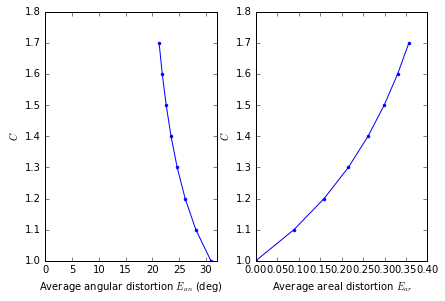

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2) # make figure and axis
f.tight_layout()
ax1.plot(Ean_ecp_C*180/np.pi,C_range,'b.-')
ax1.set_xlabel('Average angular distortion $E_{an}$ (deg)')
ax1.set_ylabel('$C$')
ax1.set_xlim(xmin=0)
ax2.plot(Ear_ecp_C,C_range,'b.-')
ax2.set_xlabel('Average areal distortion $E_{ar}$')
ax2.set_ylabel('$C$')
ax.set_xlim(xmin=0)
plt.show()

The same trend is observed: the average angular distortion $E_{an}$ shrinks and the avergae area distortion $E_{ar}$ grows as $C$ grows. The projection is equivalent for $C=1$, and loses its equivalence for $C>1$ in return for lower angular distortion.

### Ex. 4: Conformal Cylindrical Projection and Equivalent Cylindrical Projection with varying Miller Coefficients, measured using Average Linear Scalefactor
For all projections in Ex. 2 and Ex. 3, compute and plot the average mean linear distortion vs. $C$.

Try it yourself!

### Takeway from this course
There will be no coding or pc-session in the exam. 

However, you are expected to understand the main insights about projection optimisation from this course. Make sure you: 

- know which parameters one can tune
- how average distortion is computed from local distortion
- which distortion measures one can use
- what are the options to optimise equivalent, conformal and other projections
- how you expect the local distortion * surface to vary by latitude for the main projection types and how and why this changes with the tuned parameter value
- how the average distortion depends on the parameter
- ...